  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1486k  100 1486k    0     0   217k      0  0:00:06  0:00:06 --:--:--  278k


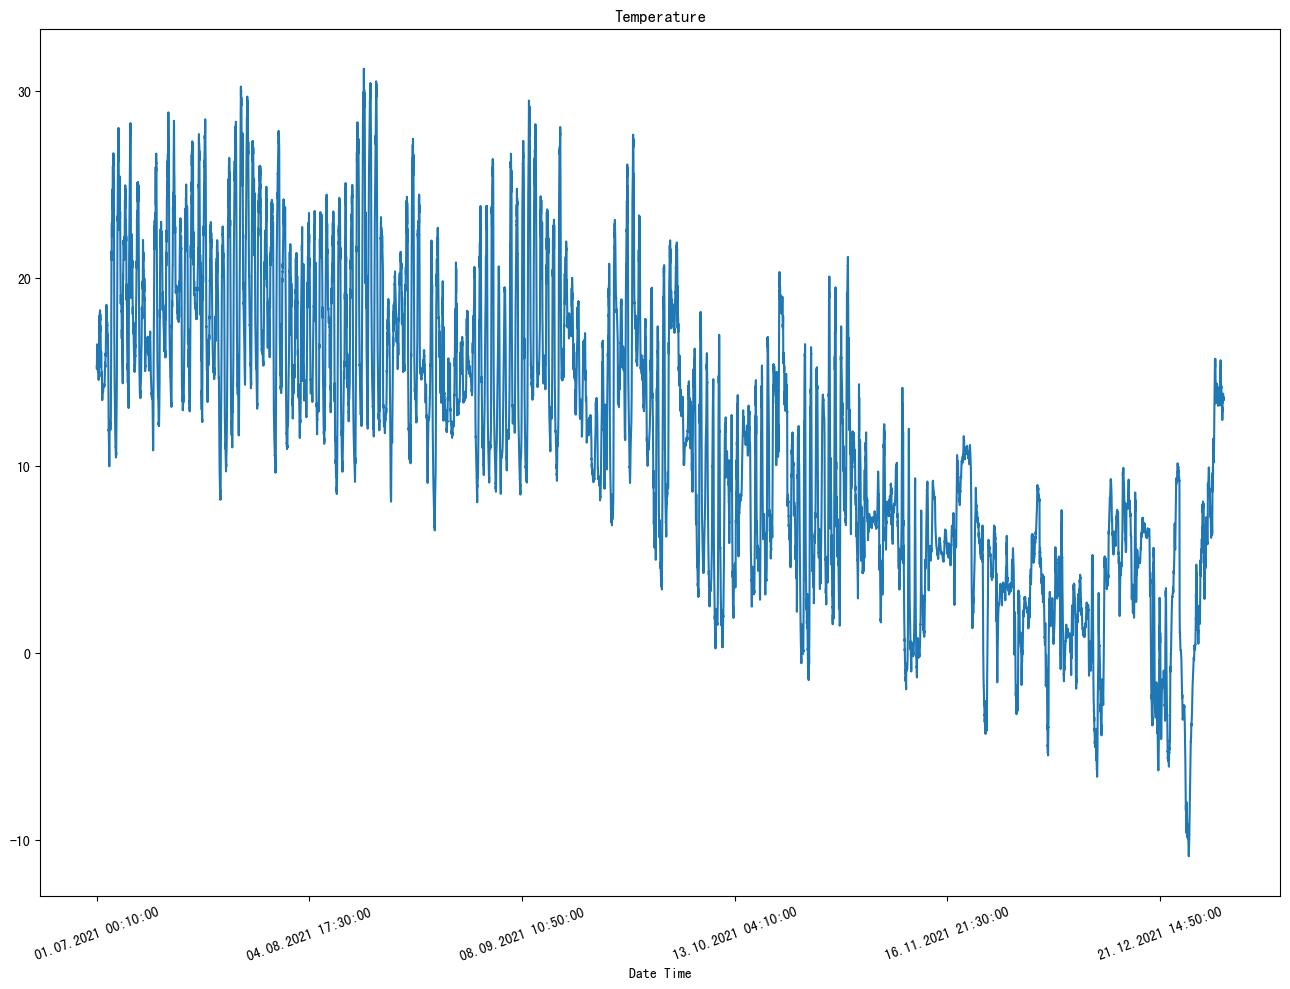

2024-05-14 02:51:28.773710: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-05-14 02:51:28.773758: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-05-14 02:51:28.773797: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2024-05-14 02:51:28.774174: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "Weather_forecaster"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 72, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
325/325 [==============================] - 8s 21ms/step - loss: 0.3904 - val_loss: 0.4768
Epoch 2/15
325/325 [==============================] - 7s 20ms/step - loss: 0.2171 - val_loss: 0.3467
Epoch 3/15
325/325 [==============================] - 7s 20ms/step - loss: 0.1963 - val_loss: 0.3143
Epoch 4

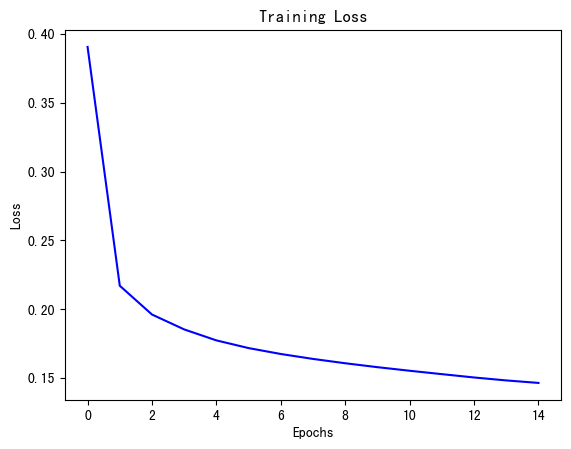

Mean Squared Error: 12.658999094992076


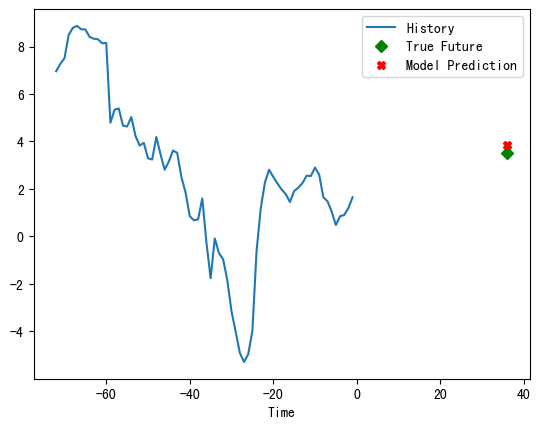

In [1]:
!curl https://www.bgc-jena.mpg.de/wetter/mpi_saale_2021b.zip -o mpi_saale_2021b.zip
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from tensorflow import keras
from sklearn.metrics import mean_squared_error

# 下载并解压数据
zip_file = zipfile.ZipFile("mpi_saale_2021b.zip")
zip_file.extractall()
csv_path = "mpi_saale_2021b.csv"
data_frame = pd.read_csv(csv_path)

# 提取时间和温度数据
time = data_frame['Date Time']
temperature = data_frame['T (degC)']

# 可视化温度数据
plt.subplots(nrows=1, ncols=1, figsize=(13, 10))
ax = plt.subplot(1, 1, 1)
temperature.index = time
temperature.plot(rot=20)
plt.title('Temperature')
plt.tight_layout()
plt.show()

# 数据标准化
def normalize(data):
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    return (data - data_mean) / data_std

features = pd.concat([temperature], axis=1)
features.index = time
features = normalize(features.values)
features = pd.DataFrame(features)

# 划分训练和验证数据
training_size = int(0.8 * features.shape[0])
train_data = features.loc[0:training_size - 1]
val_data = features.loc[training_size:]

start = 432 + 36
end = start + training_size

x_train = train_data.values
y_train = features.iloc[start:end][[0]]

sequence_length = int(432 / 6)

# 创建训练和验证数据集
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    data=x_train,
    targets=y_train,
    sequence_length=sequence_length,
    sampling_rate=6,
    batch_size=64,
)

x_val_end = len(val_data) - start
label_start = training_size + start

x_val = val_data.iloc[:x_val_end][[i for i in range(1)]].values
y_val = features.iloc[label_start:][[0]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=6,
    batch_size=64,
)

# 构建LSTM模型
for batch in dataset_train.take(1):
    inputs, targets = batch
    
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(name="Weather_forecaster", inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

# 训练模型
history = model.fit(
    dataset_train,
    epochs=15,
    validation_data=dataset_val
)

# 绘制训练损失
loss = history.history["loss"]
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, "b", label="Training loss")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# 反标准化参数
temp_mean = temperature.mean(axis=0)
temp_std = temperature.std(axis=0)

# 预测和计算MSE
true_values = []
predictions = []

for x, y in dataset_val.skip(14):
    true_value = y[0].numpy() * temp_std + temp_mean
    prediction = model.predict(x)[0] * temp_std + temp_mean
    true_values.append(true_value)
    predictions.append(prediction)

# 计算均方误差（MSE）
mse = mean_squared_error(true_values, predictions)
print(f"Mean Squared Error: {mse}")

# 绘制预测结果
for x, y in dataset_val.skip(14):
    history_data = x[0].numpy() * temp_std + temp_mean
    true_value = y[0].numpy() * temp_std + temp_mean
    prediction = model.predict(x)[0] * temp_std + temp_mean
    time_steps = list(range(-(history_data.shape[0]), 0))
    plt.plot(time_steps, history_data)
    plt.plot(36, true_value, "gD")
    plt.plot(36, prediction, "rX")
    plt.legend(["History", "True Future", "Model Prediction"])
    plt.xlabel("Time")
    plt.show()
    break
